# COMP 579 - Assignment 3
[Ling Fei Zhang](https://github.com/Ling01234), 260985358

[Sevag Baghdassarian](https://github.com/takavor), 260980928

Brandon Ma, 260983550

In [2]:
# imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import gymnasium as gym
from tqdm import tqdm, trange
import random
import time
import matplotlib.colors as mcolors
from scipy.stats import sem
from sklearn.linear_model import LogisticRegression
import matplotlib.colors as mcolors
import torch 
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
from sklearn.neural_network import MLPClassifier

# Q-Learning Agent

In [3]:
# Actions:
# 0: left
# 1: right

# best params initialization:
ALPHA = 1/4
EPSILON = 0.25
GAMMA = 0.95
BINS = 10
EPISODES = 1000
RUNS = 10
SEED = 123
random.seed(SEED)


class Qlearning:
    def __init__(self, env, alpha, gamma, epsilon, num_episodes, num_bins, seed) -> None:
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.num_bins = num_bins
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        # self.env.seed(seed)
        self.seed = seed
        random.seed(self.seed)
        self.num_action = env.action_space.n
        self.reward = []
        self.Qvalues = np.random.uniform(low=-0.001, high=0.001,
                                         size=(num_bins, num_bins, num_bins, num_bins, self.num_action))
        self.behavior_episodes1 = []
        self.behavior_episodes2 = []
        self.behavior_episodes3 = []
        self.behavior_episodes3_undiscritized = []
        self.random_episodes1 = []
        self.random_episodes2 = []
        self.random_episodes3 = []
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], self.num_bins))
            

    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)

    def select_action(self, state, episode):
        """
        Select action given a state

        Args:
            state (4-tuple): Current state of the agent, continuous
            episode (int): Current episode of the run

        Returns:
            int: Action chosen by the agent
        """
        random.seed(self.seed)

        # lower exploration rate as we run many episodes
        if episode > 700:
            self.epsilon *= 0.99

        # epsilon greedy
        number = np.random.random()
        if number < self.epsilon:  # uniformly choose action
            return np.random.choice(self.num_action)

        # greedy selection
        state = self.discritize_state(state)
        best_actions = np.where(
            self.Qvalues[state] == np.max(self.Qvalues[state]))[0]
        return np.random.choice(best_actions)

    def simulate_episodes(self):
        """
        Simulate a specified number of episodes
        """
        for episode in range(1, self.num_episodes+1):
            (state, _) = self.env.reset()
            state = list(state)

            # run episode
            episode_reward = 0
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                action = self.select_action(state, episode)
                (next_state, reward, terminal, _, _) = self.env.step(action)
                episode_reward += reward

                next_discritized_state = self.discritize_state(
                    list(next_state))

                q_max = np.max(self.Qvalues[next_discritized_state])
                self.qlearning_update(
                    terminal, reward, action, discritized_state, q_max)

                state = next_state

            self.reward.append(int(episode_reward))

    def qlearning_update(self, terminal, reward, action, state, q_max):
        """
        Qlearning update rule

        Args:
            terminal (bool): True if at terminal state, False otherwise
            reward (int): Reward of the agent at current state
            action (int): Action taken by agent
            state (4-tuple): Discrete state of the agent
            q_max (float): Max Q value of the next state
        """
        if not terminal:
            loss = reward + self.gamma * q_max - \
                self.Qvalues[state + (action,)]
        else:
            loss = reward - self.Qvalues[state + (action,)]

        self.Qvalues[state + (action,)] += self.alpha * loss

    def visualize(self, games):
        """
        Visualize the game played for a specified number of games.
        Prints out the reward for each game.

        Args:
            games (int): Number of games to be played
        """
        random.seed(self.seed)
        env = gym.make("CartPole-v1", render_mode="human")
        for game in range(games):
            (state, _) = env.reset()
            env.render()
            rewards = 0

            for _ in range(500):
                discritized_state = self.discritize_state(state)
                best_actions = np.where(self.Qvalues[discritized_state] == np.max(
                    self.Qvalues[discritized_state]))[0]
                action = np.random.choice(best_actions)
                (state, reward, terminal, _, _) = env.step(action)
                rewards += int(reward)
                time.sleep(0.05)

                if terminal:
                    time.sleep(1)
                    break
            print(f"reward for game {game}: {rewards}")
        env.close()
        
    def gather_episodes_agent(self, num_episodes):
        """
        Gather num_episodes behavior episodes for simple imitation learning

        Args:
            num_episodes (int): number of behavior episodes desired

        Returns:
            int: return of simple imitation learning using Q-Learning Agent
            as expert.
        """
        self.simulate_episodes()
        print(f"reward after simulate_episode: {self.reward[-20:]}")
        for episode in trange(1, num_episodes+1):
            state, _ = self.env.reset()
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                best_actions = np.where(self.Qvalues[discritized_state] == np.max(
                    self.Qvalues[discritized_state]))[0]
                action = np.random.choice(best_actions)
                (next_state, reward, terminal, _, _) = self.env.step(action)
                discritized_next_state = self.discritize_state(next_state)
                
                if episode <= 100:
                    self.behavior_episodes1.append((discritized_state, action, reward, discritized_next_state, terminal))
                    self.behavior_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                if episode <= 250:
                    self.behavior_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                self.behavior_episodes3.append((discritized_state, action, reward, discritized_next_state, terminal))
                self.behavior_episodes3_undiscritized.append((state, action, reward, next_state, terminal))
                state = next_state

    
    def gather_episodes_random(self, num_episodes):
        """
        Gather num_episodes behavior episodes with a random agent

        Args:
            num_episodes (int): number of behavior episodes desired for simple imitation

        Returns:
            int: return by a random agent. 
        """
        for episode in trange(1, num_episodes+1):
            state, _ = self.env.reset()
            terminal = False
            while not terminal:
                discritized_state = self.discritize_state(state)
                action = self.env.action_space.sample()
                (next_state, reward, terminal, _, _) = self.env.step(action)
                discritized_next_state = self.discritize_state(next_state)
                
                if episode <= 100:
                    self.random_episodes1.append((discritized_state, action, reward, discritized_next_state, terminal))
                    self.random_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                if episode <= 250:
                    self.random_episodes2.append((discritized_state, action, reward, discritized_next_state, terminal))
                self.random_episodes3.append((discritized_state, action, reward, discritized_next_state, terminal))
                
                state = next_state
        



# Simple Imitation

In [4]:
class SimpleImitation:
    def __init__(self, env, dataset) -> None:
        self.env = env
        self.dataset = dataset
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], 10))
            
            
    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)


    def forward(self, num_episode = 1):
        """
        Perform Simple Imitation Learning with Logistic Regression

        Args:
            num_episode (int, optional): Number of games to test on. Defaults to 1.

        Returns:
            list: list of rewards from the games 
        """
        model = LogisticRegression()
        x = np.array([data[0] for data in self.dataset])
        y = np.array([data[1] for data in self.dataset])
        model.fit(x, y)
        
        rewards = []
        for _ in range(1, num_episode + 1):
            state, _ = self.env.reset()
            episode_reward = 0
            terminal = False
            while not terminal:
                state = np.array(self.discritize_state(state))
                action = model.predict(state.reshape(1, -1))[0]
                state, reward, terminal, *_ = self.env.step(action)
                episode_reward += reward
                
            rewards.append(int(episode_reward))
        return rewards
    

Here, we will run a test run on the model, and see how it performs

In [34]:
def test_model():
    env = gym.make("CartPole-v1")
    qlearning = Qlearning(env, ALPHA, GAMMA, EPSILON, EPISODES, BINS, SEED)
    qlearning.gather_episodes_agent(500)
    qlearning.gather_episodes_random(500)
    imitation_expert = SimpleImitation(env, qlearning.behavior_episodes3)
    expert_reward = imitation_expert.forward()
    imitation_random = SimpleImitation(env, qlearning.random_episodes3)
    random_reward = imitation_random.forward()
    print(f"Simple imitation with expert agent reward: {expert_reward}")
    print(f"Simple imitation with random agent reward: {random_reward}")
    env.close()
    return qlearning.behavior_episodes1, qlearning.random_episodes1, qlearning.behavior_episodes2, qlearning.random_episodes2, qlearning.behavior_episodes3, qlearning.random_episodes3,qlearning.behavior_episodes3_undiscritized
    
data_expert100, data_random100, data_expert250, data_random250, data_expert500, data_random500, data_expert_undiscritized500 = test_model()    

reward after simulate_episode: [83, 89, 105, 107, 121, 89, 81, 87, 83, 76, 95, 91, 93, 81, 87, 98, 87, 89, 93, 136]


100%|██████████| 500/500 [00:00<00:00, 1146.49it/s]

Simple imitation with expert agent reward: [156]
Simple imitation with random agent reward: [23]


We have pre-trained our Q-Learning agent with 1000 episodes, as we did in the previous assignment. We then use the trained Q-Learning agent as our expert in simple imitation learning and used logisitc regression to imitate the action observed in each state. The results above were produced using 500 behavior episodes. We can see that we can get decent results from simple imitation learning. On the other hand, we can see the returns received by the random agent. Without surprise, the returns are very low. 

# Datasets
Below, we will create the mixed datasets.

In [6]:
# Shuffled data
mixed_data_expert = random.sample(data_expert500, 500)
mixed_data_random = random.sample(data_random500, 500)
mixed_data = mixed_data_expert + mixed_data_random

# Mixed data
mixed_data100 = mixed_data_expert[:int(len(mixed_data)/10)]
mixed_data250 = mixed_data_expert[:int(len(mixed_data)/4)]
mixed_data500 = mixed_data_expert[:int(len(mixed_data)/2)]

# Fitted Q-Learning

In [36]:
# Define the MLP 
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units = 64):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.relu = nn.ReLU()
        
        self.layer1.weight.data.uniform_(-0.001, 0.001)
        self.layer1.bias.data.fill_(0)
        self.layer2.weight.data.uniform_(-0.001, 0.001)
        self.layer2.bias.data.fill_(0)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x


class FittedQLearning:
    def __init__(self, env, buffer, alpha = 0.005, gamma=0.99, num_episodes=500, batch_size=64, buffer_size=5000, approximator="linear"):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.buffer = buffer
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.approximator = approximator
        self.reward = []
        self.lowerbound = env.observation_space.low
        self.lowerbound[1] = -3.5
        self.lowerbound[3] = -10
        self.upperbound = env.observation_space.high
        self.upperbound[1] = 3.5
        self.upperbound[3] = 10
        self.bins = []
        for i in range(4):
            self.bins.append(np.linspace(
                self.lowerbound[i], self.upperbound[i], 10))
        
        if self.approximator == "linear":
            self.Qvalues = np.random.uniform(low=-0.001, high=0.001,
                                             size=(10, 10, 10, 10, self.action_space))
        
        if self.approximator == "mlp":
            print("FittedQLearning constructor with MLP function approximation...")
            self.model = MLP(self.state_space, self.action_space)
            self.opt = optim.Adam(self.model.parameters(), lr = self.alpha)
        
        
    
    def discritize_state(self, state):
        """
        Discritize continuous state into a discrete state

        Args:
            state (list of length 4): Current continuous state of agent

        Returns:
            state (4-tuple): Current discritized state of agent
        """
        new_state = []
        for i in range(4):
            index = np.maximum(np.digitize(state[i], self.bins[i]) - 1, 0)
            new_state.append(index)

        return tuple(new_state)
    
    def update(self):
        """
        Fitted Q Learning update step. This is done in batch.
        For linear function approximation, we are using tabular RL.
        We can directly minimize the mean square error to 0 by replacing
        the qvalue of a (state, action) pair by the target qvalue. 
        """
        if len(self.buffer) < self.batch_size:
            return
        
        batch_index = np.random.choice(len(self.buffer), size=self.batch_size)
        batch = [self.buffer[i] for i in batch_index]
        states, actions, rewards, next_states, dones = zip(*batch)
        
        if self.approximator == "linear":
            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            next_states = np.array(next_states)
            dones = np.array(dones)
            
            max_qvalues = np.zeros(self.batch_size)
            for index, next_state in enumerate(next_states):
                if not dones[index]:
                    next_state = self.discritize_state(list(next_state))
                    max_qvalues[index] = np.max(self.Qvalues[next_state]) 
            
            targets = rewards + self.gamma * max_qvalues # 1 x batch_size
            
            # update
            for i, target in enumerate(targets):
                state = states[i]
                state = tuple(state)
                action = actions[i]
                self.Qvalues[state + (action,)] = target
        
        else: #mlp
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)
            
            max_qvalues = torch.zeros(self.batch_size)
            for index, next_state in enumerate(next_states):
                if not dones[index]:
                    next_qvalues = self.model(next_state)
                    max_qvalues[index] = next_qvalues.max()
            max_qvalues = max_qvalues.detach()
            
            # print(f"max qvalues shape: {max_qvalues.shape}")
            # print(f"rewards shape: {rewards.shape}")
            
            targets = rewards + self.gamma * max_qvalues
            qvalues = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            # print(f"targets: {targets}")
            
            # print(f"qvalues shape: {qvalues.shape}")
            # print(f"targets shape: {targets.shape}")
            
            loss = nn.functional.mse_loss(qvalues, targets) 
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            # qvalues = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            # next_qvalues = self.model(next_states).detach().max(1)[0].unsqueeze(1)
            # targets = rewards + (1-dones)* self.gamma * next_qvalues
            
            # print(f"qvalues: {qvalues}")
            # print(f"targets: {targets}")
            
            # loss = nn.functional.mse_loss(qvalues, targets)
            # self.opt.zero_grad()
            # loss.backward()
            # self.opt.step()



    def select_action(self, state):
        """
        Select an action based on current state

        Args:
            state (4-tuple): current state of agent, discritized

        Returns:
            int: action taken based on greedy selection (i.e. no exploration)
        """
        if self.approximator == "linear":
            best_actions = np.where(
                self.Qvalues[state] == np.max(self.Qvalues[state]))[0]
            return np.random.choice(best_actions)
        else: #mlp
            q_values = self.model(torch.FloatTensor(state)).detach().numpy()
            return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        """
        add a sample to the replay buffer

        Args:
            state (4-tuple): current state of the agent
            action (int): action taken by agent
            reward (int): reward received
            next_state (4-tuple): next state of agent
            done (bool): whether the next step terminates the game
        """
        self.buffer.append((state, action, reward, next_state, done))

    def train(self):
        """
        Train the agent on a specified number of episodes
        """
        for _ in trange(1, self.num_episodes+1):
            self.update()

    def test(self, num_episode=1):
        """
        Test the trained fitted q learning agent on a simple game
        and record the return of the agent.

        Returns:
            int: return of the agent
        """
        rewards = []
        for episode in range(1, num_episode + 1):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            while not done:
                if self.approximator == "linear":
                    state = self.discritize_state(list(state))
                action = self.select_action(state)
                state, reward, done, *_ = self.env.step(action)
                episode_reward += reward

            rewards.append(int(episode_reward))
        return rewards
    

In [37]:

env = gym.make("CartPole-v1")
model = FittedQLearning(env, data_expert_undiscritized500, approximator="mlp")
model.train()
reward = model.test()
print(f"Fitted Q Learning with MLP expert data reward: {reward}")
env.close()

FittedQLearning constructor with MLP function approximation...


100%|██████████| 500/500 [00:01<00:00, 276.94it/s]

Fitted Q Learning with MLP expert data reward: [10]


We can quickly test our Fitted Q Learning, and see if the returns are to be expected. 

In [30]:
def test_model_fitted():
    env = gym.make("CartPole-v1")
    model = FittedQLearning(env, data_expert500)
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with expert data reward: {reward}")
    model = FittedQLearning(env, data_random500)
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with random data reward: {reward}")
    model = FittedQLearning(env, mixed_data500)
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with mixed data reward: {reward}")
    print("--------------------------------------------")
    model = FittedQLearning(env, data_expert_undiscritized500, approximator="mlp")
    model.train()
    reward = model.test()
    print(f"Fitted Q Learning with MLP expert data reward: {reward}")
    
    env.close()
    
test_model_fitted()

100%|██████████| 500/500 [00:00<00:00, 790.43it/s]


Fitted Q Learning with expert data reward: [201]


100%|██████████| 500/500 [00:00<00:00, 803.75it/s]


Fitted Q Learning with random data reward: [23]


100%|██████████| 500/500 [00:00<00:00, 841.92it/s]


Fitted Q Learning with mixed data reward: [169]
--------------------------------------------
FittedQLearning constructor with MLP function approximation...


  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_10156\1114182284.py:123: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(qvalues, targets, reduction="mean") # wrong way of doing this
  0%|          | 0/500 [00:00<?, ?it/s]

qvalues shape: torch.Size([64, 2])
targets shape: torch.Size([64, 64])


RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 1

From the results above, we can clearly see the effect of the datasets. With the expert data, we have the best return by agent. This is to be expected, as the agent used the best data there is. Then, we observed a very low return by the agent when trained using random data. This is essentially the same as not learned anything, i.e. just taking actions randomly. Lastly, when we mixed the expert data and the random data, we observed a decent return, but not as good as the return by the first agent. This is also natural, as the agent was able to partly learn from the expert data. 

# Bar Plots

First, we define a function to plot the bar plots

In [18]:
def plot(size):
    env = gym.make("CartPole-v1")
    if size == 100:
        expert = data_expert100
        rand = data_random100
        mixed = mixed_data100
    elif size == 250:
        expert = data_expert250
        rand = data_random250
        mixed = mixed_data250
    else: # size == 500
        expert = data_expert500
        rand = data_random500
        mixed = mixed_data500
    
    imitation_expert = SimpleImitation(env, expert)
    imitation_reward_expert = imitation_expert.forward(100)
    imitation_se_expert = np.std(imitation_reward_expert)/np.sqrt(len(imitation_reward_expert))
    imitation_reward_expert = np.mean(imitation_reward_expert)
    
    imitation_random = SimpleImitation(env, rand)
    imitation_reward_random = imitation_random.forward(100)
    imitation_se_random = np.std(imitation_reward_random)/np.sqrt(len(imitation_reward_random))
    imitation_reward_random = np.mean(imitation_reward_random)
    
    imitation_mixed = SimpleImitation(env, mixed)
    imitation_reward_mixed = imitation_mixed.forward(100)
    imitation_se_mixed = np.std(imitation_reward_mixed)/np.sqrt(len(imitation_reward_mixed))
    imitation_reward_mixed = np.mean(imitation_reward_mixed)
    
    fitted_expert = FittedQLearning(env, expert)
    fitted_expert.train()
    fitted_reward_expert = fitted_expert.test(100)
    fitted_se_expert = np.std(fitted_reward_expert)/np.sqrt(len(fitted_reward_expert))
    fitted_reward_expert = np.mean(fitted_reward_expert)
    
    fitted_random = FittedQLearning(env, rand)
    fitted_random.train()
    fitted_reward_random= fitted_random.test(100)
    fitted_se_random = np.std(fitted_reward_random)/np.sqrt(len(fitted_reward_random))
    fitted_reward_random= np.mean(fitted_reward_random)
    
    fitted_mixed = FittedQLearning(env, mixed)
    fitted_mixed.train()
    fitted_reward_mixed = fitted_mixed.test(100)
    fitted_sd_mixed = np.std(fitted_reward_mixed)/np.sqrt(len(fitted_reward_mixed))
    fitted_reward_mixed = np.mean(fitted_reward_mixed)
    
    average_expert = (imitation_reward_expert + fitted_reward_expert)/2
    average_random = (imitation_reward_random + fitted_reward_random)/2
    
    model = ["Simple Imitation Expert", "Simple Imitation Random", "Simple Imitation Mixed", "FittedQLearning Expert", "FittedQLearning Random", "FittedQLearning Mixed"]
    returns = [imitation_reward_expert, imitation_reward_random, imitation_reward_mixed, fitted_reward_expert, fitted_reward_random, fitted_reward_mixed]
    errors = [imitation_se_expert, imitation_se_random, imitation_se_mixed, fitted_se_expert, fitted_se_random, fitted_sd_mixed]
    colors = [mcolors.TABLEAU_COLORS["tab:blue"],
              mcolors.TABLEAU_COLORS["tab:green"], 
              mcolors.TABLEAU_COLORS["tab:orange"],
              mcolors.TABLEAU_COLORS["tab:purple"],
              mcolors.TABLEAU_COLORS["tab:cyan"],
              mcolors.TABLEAU_COLORS["tab:brown"],
              ]
    
    plt.bar(model, returns, color=colors, yerr=errors, capsize=5)
    plt.ylabel("Average Return")
    plt.xlabel("Agent")
    plt.xticks(rotation="vertical")
    plt.title(f"Average return by Agent with {size} episodes")
    
    xlimit = plt.xlim()[1]
    handles = [plt.Rectangle((0,0), 1, 1, color=color) for color in colors]
    plt.legend(handles, model, loc="best", bbox_to_anchor = (1, 0.7))
    plt.axhline(y=average_expert, color="black", linestyle="dashed")
    plt.text(xlimit + 0.2, average_expert, f"Expert Average: {average_expert:.3}", va="center", ha="left", color="black", fontsize=10)
    plt.axhline(y=average_random, color="red", linestyle="dashed")
    plt.text(xlimit + 0.2, average_random, f"Random Average: {average_random:.3}", va="center", ha="left", color="red", fontsize=10)
    plt.show()
    
        

Now, we can call the function to actually plot our 3 plots, 1 plot for each **size** of the dataset.

100%|██████████| 500/500 [00:00<00:00, 843.77it/s]


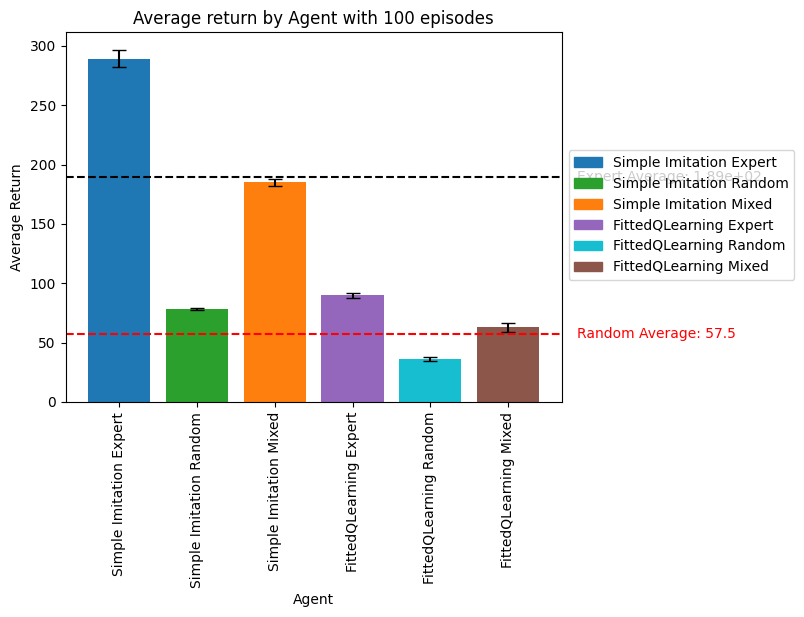

100%|██████████| 500/500 [00:00<00:00, 819.58it/s]


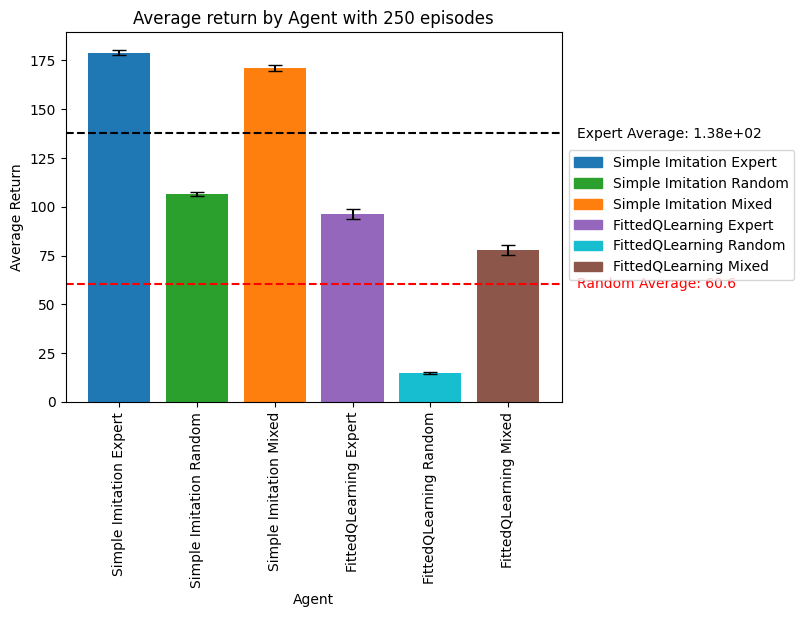

100%|██████████| 500/500 [00:00<00:00, 819.24it/s]


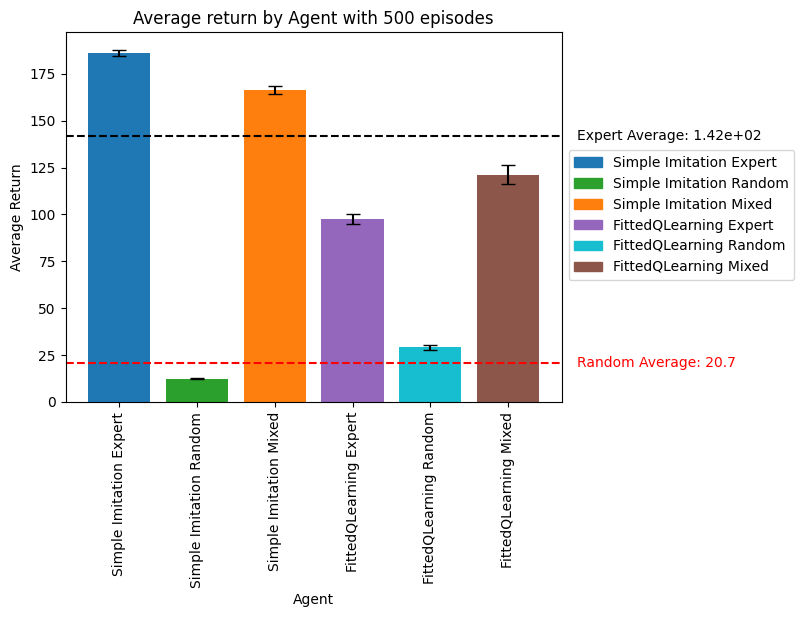

In [19]:
plot(100)
plot(250)
plot(500)

# Report

Above, we implemented two estimators: Simple Imitation and FittedQLearning. Both are offline Reinforcement Learning models, as it trains the model based on expert data, instead of gathering data as the agent plays the game. Expert data is gathered from our previously implemented QLearning model, where the agent is trained on 500 episodes. The expert data is collected during this 500-episode training, where each data point is in the form is a 5-tuple, namely (state, action, reward, next_state, done). 

## Simple Imitation

### Training

For Simple Imitation, we simply used sklearn's LogisticRegression model to perform the training. The model receives as input the state of the agent (in discrete form), and predicts the action that the agent should take. As the name of the estimator suggests, the estimator tries to imitate what is seen in the expert data. Training the model is easy, as it is simply done by calling `LogisticRegression.fit(x,y)`, where `x` represents the states and `y` represents the action taken at state `x`.  

### Result

We can see from the bar plots above the results of Simple Imitation. No matter the size of the dataset (100, 250 or 500), we can see that the estimator performs just as well as our online QLearning agent, given expert data. In other words, if the estimator is trained with proper data, then the returns are consistently high. 

Surprisingly, Simple Imitation also performed very well when given a mixed dataset of expert and random data. My expectation of the returns was somewhere in the middle, between the returns of the agent trained on expert data, and the returns of the agent trained on random data. However, it seems like the the estimator is able to match the returns received when it is trained by expert data. This can be explained by the nature of the estimator. First note that even a random agent has a 50% chance of choosing the best action. This means that if we give the estimator **some** expert data, we can increase this 50% chance to a higher percentage quite easily. As a result, since the estimator simply maps states to actions, given some expert mapping, it can quite confidently select the optimal choice.

Lastly, when we train the estimator using random data, we can see that it performs poorly. This is to be expected, because training an agent with random data is pointless. At the end, it is as if the agent just performs random actions. 

## Fitted Q Learning

### Training

The nature of Fitted Q Learning is very different relative to Simple Imitation. Simple Imitation maps states to actions, whereas Fitted Q Learning learns to minimize the temporal difference error through Qvalues. For Fitted Q Learning, we trained our agent on 500 episodes. During each episode, we perform an update by batch. This means that we first randomly select a batch of data from our buffer, and we update the function approximator $\phi$ accordingly. The update is done following the Fitted Q Iteration, where our goal is to select $\phi$ as follows 
\begin{equation*}
\phi \leftarrow \arg\min_{\phi} \frac{1}{2} \sum_i || Q_{\phi}(s_i,a_i) - y_i||^2
\end{equation*}

In the case of linear function approximation, we can squeeze the temporal difference error to 0 by simply setting the Qvalue at $(s_i, a_i)$ to be $y_i$. The training finishes after 500 episodes.

### Result

Once again, we can refer to the plots above to discuss our results. When FittedQLearning is trained with expert data, we notice that no matter the size of the dataset, the agent can perform quite well. In fact, it matches the performance of online QLearning and of Simple Imitation. This is to be expected, since the agent is being trained on a lot of expert data. 

When the agent is being trained with mixed data, we can see that the agent has difficulty keeping up when the dataset is small. To be more specific, when the dataset only consists of 100 episodes, half of which being episodes of a random agent, we can see that Fitted Q Learning is able to obtain around half of the return received by an agent trained on expert data. This is to be expected, since training on random data slows down learning, especially when there isn't much data to learn from. However, as the dataset gets bigger, we can see that Fitted Q Learning performs just as well as online QLearning even when it is trained with a mixed dataset. 

A possible explanation is that the agent has now access to a lot more data, and so even if some of it is random, it can still learn a lot from the data points that come from an expert. It is also worth noting that even though half of the episodes come from a random agent, the actual proportion of data points that come from the random agent is much **smaller** than half. This is because each game by a random agent only consists of 10 to 20 steps (data points), but each game from an expert consists of 80 to 130 steps (data points). Thus, as the number of training episodes **increase**, the proportion of random data points relative to expert data points **decreases**. 

## Conclusion

In conclusion, despite the different methods of learning by the two estimators, they were able to match the performance of online QLearning trained on 500 episodes (average return of 80-130). We observe that the size of the dataset only had an influence on Fitted Q Learning, when the agent is trained using a mixed dataset. In that case, our agent was able to obtain about half of the return obtained by online QLearning. Other than this specific case, we notice that the size of the dataset didn't have much influence on the other combinations of estimator + type of data. In fact, every other combination was able to match the performance of the policy used to generate the expert data. 
